# Evaluate the encoder

In [4]:
import logging
from dask.distributed import Client, LocalCluster

In [5]:
dask_logger = logging.getLogger("distributed.utils_perf")
dask_logger.setLevel(logging.ERROR)

In [6]:
dask_client = Client(LocalCluster(
    n_workers=20,
    threads_per_worker=1))

In [7]:
dask_client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 10
Total threads: 10,Total memory: 31.16 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36517,Workers: 10
Dashboard: http://127.0.0.1:8787/status,Total threads: 10
Started: Just now,Total memory: 31.16 GiB
Comm: tcp://127.0.0.1:42505,Total threads: 1
Dashboard: http://127.0.0.1:37641/status,Memory: 3.12 GiB
Nanny: tcp://127.0.0.1:44401,


## Unks

In [20]:
import pandas as pd
from tqdm.auto import tqdm
from transformers import AutoTokenizer

from cai_common.data import KangyurLoader, TengyurLoader

In [2]:
tokenizer = AutoTokenizer.from_pretrained(
    "facebook/nllb-200-distilled-600M", src_lang="bod_Tibt"
)

In [4]:
kangyur_df = KangyurLoader().remove_new_lines().dataframe.compute()

In [5]:
tengyur_df = TengyurLoader().remove_new_lines().dataframe.compute()

In [6]:
len(kangyur_df), len(tengyur_df)

(65461, 128630)

In [12]:
text = kangyur_df.text.tolist()
text.extend(tengyur_df.text.tolist())
len(text)

194091

In [14]:
tokenized = [tokenizer.encode(l) for l in tqdm(text)]

  0%|          | 0/194091 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (6539 > 1024). Running this sequence through the model will result in indexing errors


### Total Unk counts

In [17]:
flattened = [t for l in tokenized for t in l]
len(flattened)

87885924

In [26]:
token_counts = pd.Series(flattened).value_counts()

In [28]:
token_counts[tokenizer.unk_token_id] / token_counts.sum()

0.001979452363725504

### Unk densities

In [29]:
unk_counts = [sum([t == tokenizer.unk_token_id for t in l]) for l in tqdm(tokenized)]

  0%|          | 0/194091 [00:00<?, ?it/s]

In [39]:
unk_counts = pd.Series(unk_counts).value_counts().sort_index()
unk_counts

0      161945
1       11327
2        5460
3        3162
4        2171
        ...  
128         1
160         1
161         1
200         1
373         1
Length: 94, dtype: int64

In [43]:
1 - unk_counts[unk_counts > 1].sum() / unk_counts.sum()

8.243555857823104e-05

## Tibetan vocabulary

In [4]:
import unicodedata

from transformers import AutoTokenizer

In [47]:
tokenizer = AutoTokenizer.from_pretrained("facebook/nllb-200-distilled-600M", src_lang="bod_Tibt")

In [41]:
list(tokenizer.vocab.keys())[0]

'▁indflydelse'

In [48]:
def _is_tibetan(word):
    excluded = {"▁", "", "", "", "", "", "", "", "", "", "", "", "", "", "", "", "", "", "", "", "", "", "", "", "", "", "", "", "฀", "", "", ""}
    return all(['TIBETAN' in unicodedata.name(c) for c in word if not c in excluded])

In [49]:
tibetan = [_is_tibetan(w) for w in list(tokenizer.vocab.keys())]

In [50]:
sum(tibetan)

2951

In [45]:
test_str = "།མུ་སྟེགས་ཚོགས་རྣམས་ཐམས་ཅད་རབ་བཅོམ་སྟེ།"

In [46]:
tokenizer.decode(tokenizer.encode(test_str))

'།མུ་སྟེགས་ཚོགས་རྣམས་ཐམས་ཅད་རབ་བཅོམ་སྟེ།</s>bod_Tibt'

# Basic dataset statistics

In [1]:
from itertools import islice
from datasets import load_dataset

import numpy as np
import pandas as pd

In [2]:
nllb_data = load_dataset("allenai/nllb", 'bod_Tibt-eng_Latn')['train']

Generating train split:   0%|          | 0/714577 [00:00<?, ? examples/s]

Dataset nllb downloaded and prepared to /home/eeisenst/.cache/huggingface/datasets/allenai___nllb/bod_Tibt-eng_Latn/1.0.0/28d4a24ef4e17a539baee89254dc6a56e75b1a7a10b1055757f2512af99f5b30. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
nllb_data = pd.DataFrame(nllb_data)

In [11]:
nllb_data['eng_len'] = nllb_data.apply(lambda x: len(x['translation']['eng_Latn']), axis=1)

In [14]:
nllb_data.eng_len.describe()#percentiles=np.arange(0., 1., 0.1))

count    714577.000000
mean         43.715713
std          37.405826
min           7.000000
25%          23.000000
50%          32.000000
75%          49.000000
max         499.000000
Name: eng_len, dtype: float64

# LASER score exploration

In [26]:
from itertools import islice
from datasets import load_dataset

import numpy as np
import pandas as pd

In [3]:
nllb_data = load_dataset("allenai/nllb", 'bod_Tibt-eng_Latn')['train']

Found cached dataset nllb (/home/eeisenst/.cache/huggingface/datasets/allenai___nllb/bod_Tibt-eng_Latn/1.0.0/28d4a24ef4e17a539baee89254dc6a56e75b1a7a10b1055757f2512af99f5b30)


  0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
nllb_data[0]

{'translation': {'bod_Tibt': 'ཞལ་ཆད་ དང་ ཁས་ལེན་ ཐོབ་ཅེས་ལ་།',
  'eng_Latn': 'That is your contract with God."'},
 'laser_score': 1.2493345737457275,
 'source_sentence_lid': 0.8996099829673767,
 'target_sentence_lid': 1.0,
 'source_sentence_source': 'crawl-data/CC-MAIN-2019-43/segments/1570986692723.54/wet/CC-MAIN-20191019090937-20191019114437-00393.warc.wet.gz',
 'source_sentence_url': 'http://lbj.biblesindia.com/lbj/mlsp-dl/420/24669/204851?r=0',
 'target_sentence_source': 'crawl-data/CC-MAIN-2021-04/segments/1610703524743.61/wet/CC-MAIN-20210121101406-20210121131406-00304.warc.wet.gz',
 'target_sentence_url': 'http://www.lynnesachs.com/1997/09/11/biography-of-lilith-transcript/'}

In [6]:
nllb_data_df = pd.DataFrame(nllb_data)

<AxesSubplot:>

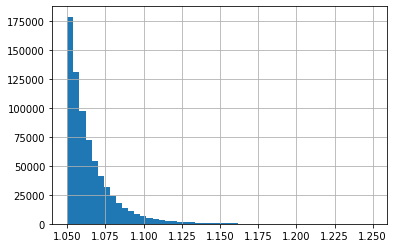

In [8]:
nllb_data_df.laser_score.hist(bins=50)

In [17]:
nllb_data_df.laser_score.describe(percentiles=np.arange(0., 1., 0.1))

count    714577.000000
mean          1.065074
std           0.016650
min           1.050000
0%            1.050000
10%           1.051454
20%           1.053088
30%           1.054971
40%           1.057169
50%           1.059791
60%           1.063088
70%           1.067430
80%           1.073714
90%           1.084979
max           1.249335
Name: laser_score, dtype: float64

In [47]:
for _, row in nllb_data_df[(nllb_data_df.laser_score > 1.15) & (nllb_data_df.laser_score < 1.20)].sample(n=20).iterrows():
    print(row.translation['bod_Tibt'])
    print(row.translation['eng_Latn'])
    print()

མདུན་ངོས། / ང་ཚོའི་སྐོར། / སློབ་སྟོན་ལྷན་ཚོགས།
They guide and teach us,...

དེས་ན་མཉམ་པར་ཁྱོད་བཞེད་ལགས། ༎ 42 ༎
[e]Which is in order unto the fear of thee.

ཁྱེད་ ང་ཚོ་སངས་རྒྱས་པའི་ཆོས་བྱེད་མཁན་རྒྱ་མི་ ཡོ ང ་གི ་ རེ ད །
This is not what our religion teaches us."

༢༠༠༩ ཕྱི་ཟླ་ ༩ ཚེས་ ༢༩ རེས་གཟའ་དམིག་དམར།
How do you not know you are nine months pregnant, and about to birth?

ཐུབ་བསྟན། བྱིས་པ། ལོ༡༣ དམའ་འབྲིང་སློབ་མ།
What if a young child [were] to lose a dog that they have had their entire life?

   ༄༅།། མོའི་གྲོང་རྡལ། མོའི་སྲིང་བལ། - བསྒྱུར་རྩོམ། - མདོ་ལྷོ་དྲ་བ།-甘南香巴拉在线
When he got back into town he was hailed by his older sister, who was carrying a Save the Earth sign.

ཁྱེད་ ང་ཚོ་སངས་རྒྱས་པའི་ཆོས་བྱེད་མཁན་རྒྱ་མི་ ཡོ ང ་གི ་ རེ ད །
"They (the law firm) were our saviors."

晋升职务 འགན་གནས་སྤར་བ།
Make it about what's in it for them (WIIFT) as opposed to what's in it for you (WIIFY).

ཁྱེད་ ང་ཚོ་སངས་རྒྱས་པའི་ཆོས་བྱེད་མཁན་རྒྱ་མི་ ཡོ ང ་གི ་ རེ ད །
The Jews were indeed our ancestors in the Faith